In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melanoma-cancer-dataset/test/Benign/6588.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6399.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6324.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/7222.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6560.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6943.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6365.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6459.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6653.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/7006.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6925.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/7245.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6800.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6899.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6831.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/7061.jpg
/kaggle/input/melanoma-cancer-dataset/test/Benign/6337.j

In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
BASE_DIR = "/kaggle/input/melanoma-cancer-dataset/"  
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)  
BATCH_SIZE = 32

In [4]:
 train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary" 
)
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)
print("Class Mapping:", train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


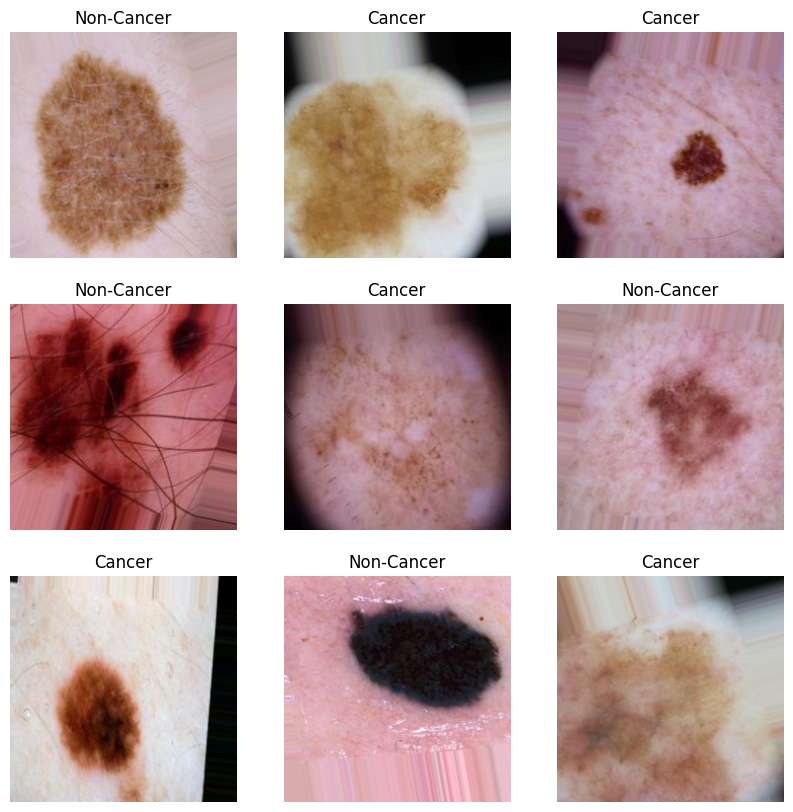

In [6]:
def plot_images(generator):
    images, labels = next(generator)  
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Non-Cancer")
        plt.axis("off")
    plt.show()
plot_images(train_generator)

In [7]:
# Build the CNN model
model = models.Sequential([
    # 1st Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # 2nd Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # 3rd Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flattening Layer
    layers.Flatten(),
    
    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid')  
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam',  # Optimizer for faster convergence
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])  # Accuracy metric

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  
    restore_best_weights=True,
    verbose=1
)

In [10]:
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,  
    min_lr=1e-7,
    verbose=1
)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,  
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


371/371 ━━━━━━━━━━━━━━━━━━━━ 199s 503ms/step - accuracy: 0.6903 - loss: 0.8515 - val_accuracy: 0.8266 - val_loss: 0.3768 - learning_rate: 0.0010
Epoch 2/20
  1/371 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.6562 - loss: 0.5772

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6562 - loss: 0.5772 - val_accuracy: 0.9375 - val_loss: 0.1981 - learning_rate: 0.0010
Epoch 3/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 137s 363ms/step - accuracy: 0.8149 - loss: 0.4103 - val_accuracy: 0.8332 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 4/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - accuracy: 0.8125 - loss: 0.3239 - val_accuracy: 0.7500 - val_loss: 0.5087 - learning_rate: 0.0010
Epoch 5/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8194 - loss: 0.4001
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
371/371 ━━━━━━━━━━━━━━━━━━━━ 137s 362ms/step - accuracy: 0.8194 - loss: 0.4001 - val_accuracy: 0.8599 - val_loss: 0.3423 - learning_rate: 0.0010
Epoch 6/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - accuracy: 0.9062 - loss: 0.2658 - val_accuracy: 0.9375 - val_loss: 0.2702 - learning_rate: 3.0000e-04
Epoch 7/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 139s 368ms/step - accuracy: 0.8407 - loss: 0

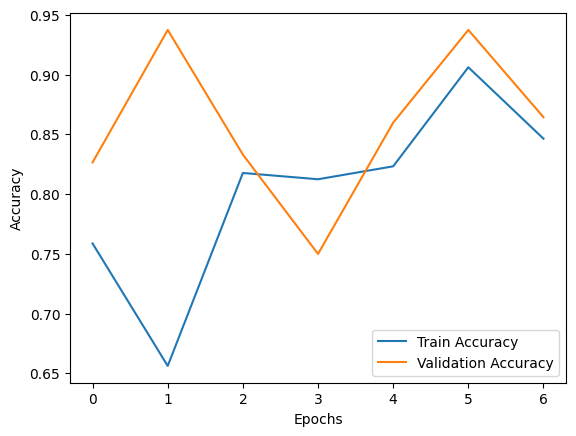

In [12]:
model.save("skin_cancer_cnn1.h5")
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1000
           1       0.49      0.44      0.47       984

    accuracy                           0.49      1984
   macro avg       0.49      0.49      0.49      1984
weighted avg       0.49      0.49      0.49      1984



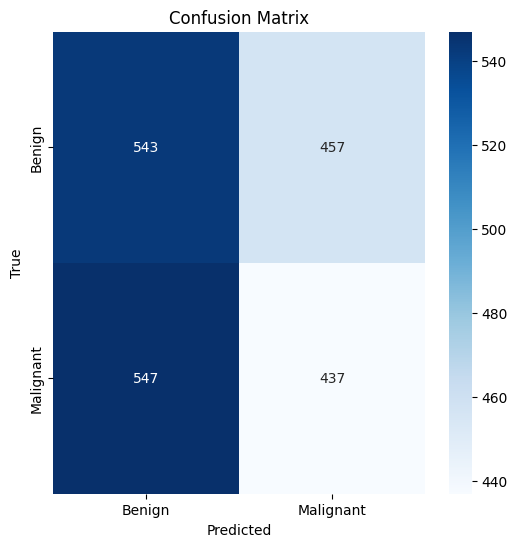

In [13]:
# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# Convert predictions to binary labels (0 or 1)
test_pred_labels = (test_pred > 0.5).astype("int32")

# Get the true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]  # Match length to predictions

# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/kaggle/working/skin_cancer_cnn1.h5')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))  # Load Image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make Prediction
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    
    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


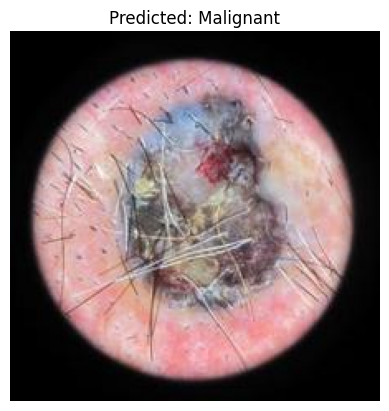

In [15]:
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Malignant/5616.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


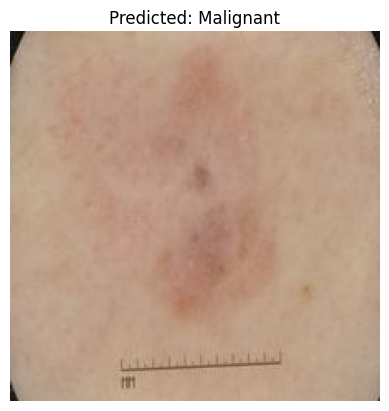

In [16]:
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/train/Malignant/1004.jpg", model)
